# Explainable Boosting Machine (EBM) - REVISED

Ommit using month and year as features, such as freyberger et al.

In [1]:
import wandb
wandb.login()

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Failed

True

In [2]:
# import basic libraries
from datetime import datetime
import pickle

from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
import matplotlib.pyplot as plt
%matplotlib inline
#pt.style.use("seaborn")
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.utils import data_loader, time_series_splitter
from src.ebm.plot import visualize_sample_prediction, importance_bar_chart
from src.ebm.train import EbmPipeline, save_model, load_model

root_path = "./data/"
model_dir = "./models/ebm/"

In [3]:
# configure interpret to plot in notebook not using a local host
from interpret.provider import InlineProvider
from interpret import set_visualize_provider

set_visualize_provider(InlineProvider())

In [4]:
subsample_path = 'subsample_processed_scaled_1000.csv'
#subsample = data_loader(root_path, subsample_path, pickle=False)
#subsample.shape'

In [5]:
# Load full dataset with multiindex enabled
fullsample_path = 'data_processed_scaled.pkl'
#fullsample = data_loader(root_path, fullsample_path, pickle=True)
#data.shape

### Hyperparameter tuning
(https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399)

In [6]:
from skopt import BayesSearchCV

# Lets try Bayesian search first
X_train, X_test, _, y_train, y_test, _ = time_series_splitter(subsample)

In [7]:
# Bayesian Search for hyperparm tuning
n_iter = 32

param_grid = {
    "learning_rate": (0.0001, 0.1, "log-uniform"),
    "max_rounds": (3000, 4000,  5000, 6000) ,
    "early_stopping_rounds": (30, 50),
    "max_bins": (128, 256),
    "early_stopping_tolerance" : (0.00001, 0.01, "log-uniform")
}

reg_bay = BayesSearchCV(estimator=ExplainableBoostingRegressor(random_state=0, n_jobs=-2),
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=5,
                    n_jobs=8,
                    scoring='neg_mean_squared_error',
                    random_state=0)

start_time = datetime.now()

# Run Bayes Search (this takes a while)
model_bay = reg_bay.fit(X_train, y_train)

execution_time = (datetime.now() - start_time).total_seconds()
print(f"Optimization took {np.round(execution_time/60),2} minutes.")

# model can be saved, used for predictions or scoring
best_parms = model_bay.best_params_

with open(f'best_params_ebm.pkl', 'wb') as f:
        pickle.dump(best_parms, f)

Optimization took (12.0, 2) minutes.


In [11]:
with open(f'{model_dir}best_params_ebm.pkl', 'wb') as f:
        pickle.dump(best_parms, f)

In [12]:
# model can be saved, used for predictions or scoring
best_parms = model_bay.best_params_
best_score = model_bay.best_score_
best_estimator = model_bay.best_estimator_
cv_results = model_bay.cv_results_
print(f"Best params are: {best_parms} \n with best score of {best_score} ")

Best params are: OrderedDict([('early_stopping_rounds', 38), ('early_stopping_tolerance', 3.91595624545083e-05), ('learning_rate', 0.00025746896437686993), ('max_bins', 164), ('max_rounds', 4000)]) 
 with best score of -0.012647079720771882 


In [9]:
# fixed best parms identified by bayessearch and experiments and rounded them
best_parms_0 = dict([('early_stopping_rounds', 37), ('early_stopping_tolerance', 0.0002), 
                    ('learning_rate', 0.00061), ('max_bins', 230), ('max_rounds', 3000)])

best_params_1 = dict([('early_stopping_rounds', 37), ('early_stopping_tolerance', 0.00020919480782183626), 
                     ('learning_rate', 0.000609840586504895), ('max_bins', 230), ('max_rounds', 3000)])

with open(f'best_params_ebm_0.pkl', 'wb') as f:
        pickle.dump(best_parms_0, f)

## Modelling

Split data into train and test sets using slicing (like in https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37). <br/>

Set sizes according to Freyberger et al, 2019 (p.2356):

Train size: 1965 to 1985
Test size: 1986 to 1990

In [6]:
# load saved hyperparams
with open(f'{model_dir}best_params_ebm.pkl', 'rb') as f:
        best_parms = pickle.load(f)

In [4]:
def normalize_target(data):
    """
    Normalizes target variable y of a dataset.
    """
    scaler = StandardScaler()
    target = data.TARGET.values.reshape(-1, 1)
    #print(target.shape)
    data['TARGET'] = scaler.fit_transform(target)
    return data

## Train on subsample

In [5]:
# Training procedure
model = ExplainableBoostingRegressor(random_state=0)

# setup hyperparams
param_dict = dict(best_parms)
model.set_params(**param_dict)

##### get data (without extra features to be comparable with freyberger et al)########
data = subsample
# normalize target
data = normalize_target(data)
print("Dataset has shape: ", data.shape)

# remove cols not used by freyberger
try:
    data.drop(['mm_sin', 'mm_cos', 'yy', 'stock'], axis=1, inplace=True) # cols can only be dropped once
except:
    pass
print("Dataset has shape ", data.shape)

# split the data
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(subsample)

model.fit(X_train, y_train)

ebm_global = model.explain_global()
#show(ebm_global)

ebm_local = model.explain_local(X_test[:5], y_test[:5])
#show(ebm_local)

Dataset has shape:  (220700, 68)
Dataset has shape  (220700, 64)


In [12]:
# evaluate
r2_val = model.score(X_valid, y_valid)
r2_train = model.score(X_train, y_train)

print("--------- Train performance---------: \n" )
print(f"Train r-squared: {r2_train} \n Val r-sqaured: {r2_val}")

y_pred_val = model.predict(X_valid[0:2000]) 
y_pred_test = model.predict(X_test[0:2000]) # limit preds to 2000 instances

# test mse, mae
mae_val = mean_absolute_error(y_test[0:2000], y_pred_test) 
mse_val = mean_squared_error(y_test[0:2000], y_pred_test)

# test mse, mae
mae_test = mean_absolute_error(y_test[0:2000], y_pred_test) 
mse_test = mean_squared_error(y_test[0:2000], y_pred_test)

print(f"\n -----------Test Performance.............: \n MAE {mae_test} \n MSE: {mse_test}")

--------- Train performance---------: 

Train r-squared: 0.059266374673811684 
 Val r-sqaured: -0.02202359944639598
-----------Test Performance.............: 
 MAE 0.7876007245196518 
 MSE: 1.503936961872742


In [9]:
# get feature imprtances from global explan object
importances_dict = ebm_global.data()
try:
    importances_dict.pop('type')
except:
    pass

feature_importance_df = pd.DataFrame(importances_dict)
feature_importance_df.rename(columns={"names": "feature", "scores": "importance score"}, inplace=True)

/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/ebm/plot.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance_df.sort_values(by='importance score', ascending=False, axis=0, inplace=True)


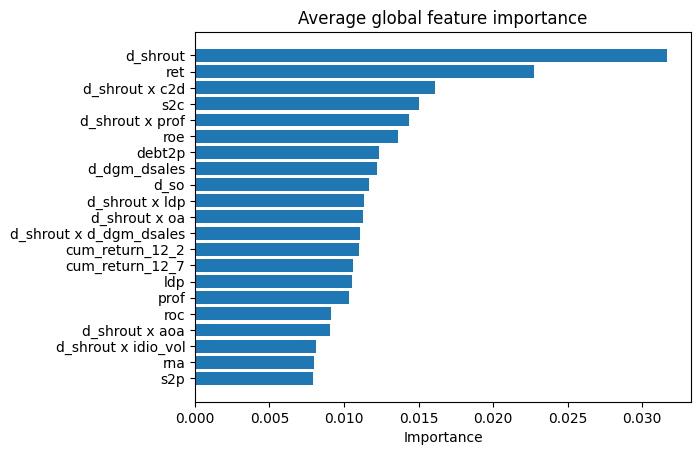

<Figure size 640x480 with 0 Axes>

In [17]:
importance_bar_chart(feature_importance_df[0:21], save=True, id='wo_temporals')

In [83]:
mae = mean_absolute_error(y_pred, y_valid)
mse = mean_squared_error(y_pred, y_valid)
print(f"Model scored with MAE: {mae} \n and an MSE of: {mse}")

Model scored with MAE: 0.08221856630920614 
 and an MSE of: 0.014490251046745324


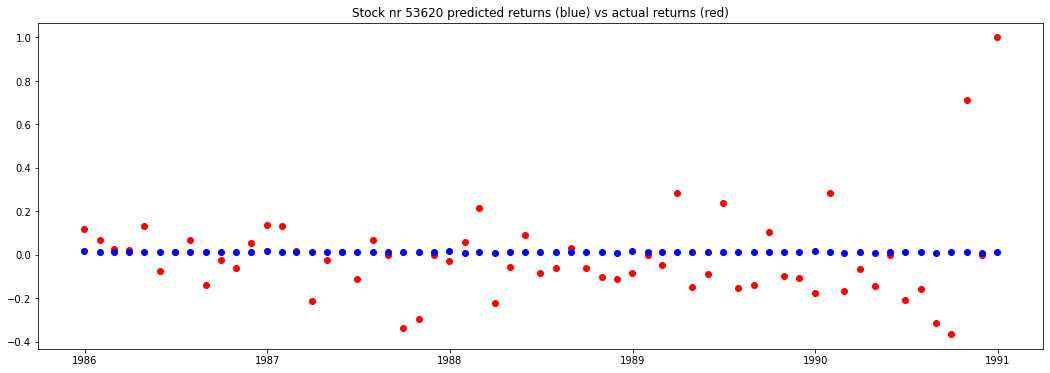

In [88]:
## lets see the preds visualized
visualize_sample_prediction(pipe.y_valid, y_pred, subsample)

## Experiment: Train on fullsample

In [30]:
wandb.finish()

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [28]:
# load saved hyperparams
with open(f'{model_dir}best_params_ebm.pkl', 'rb') as f:
        best_params = pickle.load(f)

# set up pipeline object
root_path = root_path
data_dir = fullsample_path

pipe = EbmPipeline(root_path, subsample_path, pickle=False)
pipe.param_dict = best_params
pipe.tune = True

# start training pipeline
pipeline_outputs = pipe.run()

model is being tuned


TypeError: __init__() got an unexpected keyword argument 'unbound_message'

In [31]:
model = pipe.model

explainer = model.explain_global()

explain_data = explainer.data()

sum(explain_data['scores'])

0.6317269141888073

In [32]:
# get feature imprtances from global explan object
importances_dict = explain_data
try:
    importances_dict.pop('type')
except:
    pass

feature_importance_df = pd.DataFrame(importances_dict)
feature_importance_df.rename(columns={"names": "feature", "scores": "importance score"}, inplace=True)

/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/ebm/plot.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



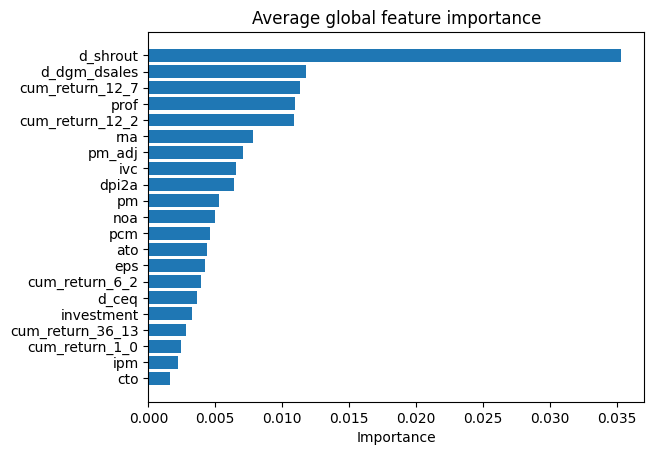

NameError: name 'model_dir' is not defined

In [34]:
importance_bar_chart(feature_importance_df[0:21], save=True, id='129')

## Pipeline - bring it all together!

In [23]:
### Helper method to visualize prediction vs true values
import matplotlib.pyplot as plt


permnos_total = subsample.index.droplevel(['date'])

def visualize_sample_prediction(y_test, y_pred):
    # Picks a random stock, to visualize its real returns 
    # against the predicted returns
    sample_permno = random.choice(permnos_total)
    ## delete:
    #sample_permno = 51625
    sample_test_y = y_test.xs(sample_permno, level='permno')
    
    sample_test_idx = sample_test_y.index.get_level_values('date')
    
    y_pred = pd.Series(y_pred, index=y_test.index)
    sample_pred = y_pred.xs(sample_permno, level='permno')
    
    
    fig,ax=plt.subplots(figsize=(18,6))

    ax.scatter(x=sample_test_idx, y= sample_test_y, color='r')
    ax.scatter(x=sample_test_idx, y= sample_pred, color='b')
    plt.title(f'Stock nr {sample_permno} predicted returns (blue) vs actual returns (red)')

### Round 1 - all features

In [29]:
## Can we extract the learned functions??
X_valid = pipe_run_1[-4]
fitted_model = pipe_run_1[-1]
fct = fitted_model.decision_function(X_valid) # not sure what exactly this is doing...

### Selected features accroding to Freyberger et al (2019) and previous student

In [8]:
## best features used by freyberger et al:
features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 'pm_adj', 
                       'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 'rel_to_high_price', 
                       'roc','suv', 'total_vol','TARGET']

## best features found by random forrest reg
features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']

features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'cto', 'TARGET']

# combines features from different feature selection methods
features_combined = ['ato', 'yy', 'spread_mean', 'cum_return_12_7', 'ret',
                     'd_so', 'd_dgm_dsales', 'lturnover', 'roe', 'mm_sin',
                     'ipm', 'dpi2a', 'beme', 'nop', 'lme', 'suv', 'dto', 'noa',
                     'd_shrout', 'total_vol', 'free_cf', 'cum_return_1_0', 'mm_cos',
                     'roc', 'e2p', 'oa', 'cto', 'rna', 'pm_adj', 'std_volume',
                     'rel_to_high_price', 'cum_return_12_2', 'investment', 'TARGET']

In [ ]:
## Ok, lets randomly pick a subset of features to see if we can at least achieve reasonable performance

features = ['d_shrout', 'lme', 'lme_adj', 'lturnover', 'rel_to_high_price',
       'ret_max', 'spread_mean', 'std_turn', 'std_volume', 'suv', 'total_vol',
       'ret', 'yy', 'mm_cos', 'mm_sin', 'stock', 'TARGET']

#train_random = data[features]
#valid_random = data[features]

-0.2906621707797341


## conclusion:

Using the union of features of the three methods did not improve but slitely decrease accuracy.
=> More features are not necessarily better.
=> More tuning does not help either 

**Two more ideas**

1) visualize results in an aggregated way: mean returns over all stocks per month e.g.

2) use only a few features, i.e. the top 3 of the above methods + returns (maximum)

A thought: standardize per stock not globally - would this change model performanee?